In [272]:
from alpaca_trade_api.rest import REST, TimeFrame
from alpaca_trade_api.entity import (
    Bar, Entity, Account, AccountConfigurations, AccountActivity,
    Asset, Order, Position, BarSet, Clock, Calendar,
    Aggs, Trade, Quote, Watchlist, PortfolioHistory
)

api = REST(key_id="PKX7NWBTMYXT2JU5FBVS", secret_key="FgzjEqmnoHXtDQ1vBHjGCArd1khau7Q868VkJrGA")
#api = REST()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [343]:
def calculate_group_vwap(df, price, size):
    dff = df.copy()
    dff['pxs']= dff[price] * dff[size]
    numerator=dff['pxs'].sum()
    denom = dff[size].sum()
    vwap= numerator/denom
    print(numerator, denom, vwap)
    return vwap

In [344]:
class AlpacaDownloader:
    
    def __init__(self):
        pass
    
    def get_quotes(self, symbol, start, end, limit=10000):
        return api.get_quotes(symbol, start, end, limit=limit).df

    
    def get_trades(self, symbol, start, end, limit=10000):
        return api.get_trades(symbol, start, end, limit = limit).df


    def get_bars(self, symbol, start, end, interval=TimeFrame.Day, limit=10000):
        return api.get_bars(symbol, TimeFrame.Hour, start, end, limit=limit).df


In [345]:
ad = AlpacaDownloader()


In [305]:
aapl = ad.get_trades("AAPL", "2021-07-13", "2021-07-14", limit=3000000)
len(aapl)

1490440

In [352]:
aapl['time'] = aapl.index

In [353]:
aapl_quotes = ad.get_quotes("AAPL", "2021-07-13", "2021-07-14", limit=4000000)
len(aapl_quotes)

KeyboardInterrupt: 

In [ ]:
aapl.head(50)

In [ ]:
aapl_quotes['time'] = aapl_quotes.index

In [ ]:
aapl['trade_vwap'] = calculate_group_vwap(aapl, 'price', 'size')

In [335]:
aapl.describe()

,price,size,id,trade_vwap
count,1.490440e+06,1.490440e+06,1.490440e+06,1.490440e+06
mean,1.475413e+02,1.606878e+02,6.361298e+04,1.607315e+02
std,1.496179e+00,7.981936e+03,5.976066e+04,6.237715e-09
min,1.232773e+02,1.000000e+00,1.000000e+00,1.607315e+02
25%,1.462500e+02,1.000000e+01,1.507300e+04,1.607315e+02
50%,1.480600e+02,1.000000e+02,4.506200e+04,1.607315e+02
75%,1.489000e+02,1.000000e+02,9.466925e+04,1.607315e+02
max,1.548714e+02,5.173691e+06,2.493810e+05,1.607315e+02


In [312]:
tr_resample = aapl.resample('30min', on='time', offset='30Min10s')[['size', 'price']].mean()
qu_resample = aapl_quotes.resample('30min', on='time', offset='30Min10s')[['bid_size', 'ask_size', 'bid_price', 'ask_price']].mean()

In [313]:
merged_tr_qu = pd.merge(tr_resample, qu_resample, on="time")

In [314]:
merged_tr_qu.index = merged_tr_qu.index.tz_convert('US/Eastern') + pd.offsets.Hour(1)

In [315]:
merged_tr_qu.columns

Index(['size', 'price', 'bid_size', 'ask_size', 'bid_price', 'ask_price'], dtype='object')

In [316]:
merged_tr_qu['timestamp'] = merged_tr_qu.index.time 

In [317]:
merged_tr_qu.columns = ['trade_size', 'trade_price', 'bid_size', 'ask_size', 'bid_price', 'ask_price', 'timestamp']

In [318]:
merged_tr_qu.head(3)

,trade_size,trade_price,bid_size,ask_size,bid_price,ask_price,timestamp
time,,,,,,,
2021-07-13 04:30:10-04:00,39.619048,144.035952,3.962264,4.056604,140.892075,141.045472,04:30:10
2021-07-13 05:00:10-04:00,45.049488,144.027031,4.036212,1.838440,143.906630,144.087382,05:00:10
2021-07-13 05:30:10-04:00,28.788698,144.265971,3.185714,3.776190,144.207571,144.281190,05:30:10


In [319]:
merged_tr_qu['bid_ask_size_spread_percent'] = 100* abs(merged_tr_qu.bid_size - merged_tr_qu.ask_size)/ ((merged_tr_qu.bid_size + merged_tr_qu.ask_size)/2)
merged_tr_qu['bid_ask_price_spread_percent'] = 100* abs(merged_tr_qu.bid_price - merged_tr_qu.ask_price)/ ((merged_tr_qu.bid_price + merged_tr_qu.ask_price)/2)

In [320]:
merged_tr_qu.head(2)

,trade_size,trade_price,bid_size,ask_size,bid_price,ask_price,timestamp,bid_ask_size_spread_percent,bid_ask_price_spread_percent
time,,,,,,,,,
2021-07-13 04:30:10-04:00,39.619048,144.035952,3.962264,4.056604,140.892075,141.045472,04:30:10,2.352941,0.108816
2021-07-13 05:00:10-04:00,45.049488,144.027031,4.036212,1.838440,143.906630,144.087382,05:00:10,74.822191,0.125525


In [336]:
df = merged_tr_qu[np.abs(merged_tr_qu.bid_ask_price_spread_percent-merged_tr_qu.bid_ask_price_spread_percent.mean()) <= (3*merged_tr_qu.bid_ask_price_spread_percent.std())]
# keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.


In [338]:
df.head()

,trade_size,trade_price,bid_size,ask_size,bid_price,ask_price,timestamp,bid_ask_size_spread_percent,bid_ask_price_spread_percent,trade_vwap
time,,,,,,,,,,
2021-07-13 04:30:10-04:00,39.619048,144.035952,3.962264,4.056604,140.892075,141.045472,04:30:10,2.352941,0.108816,188.196129
2021-07-13 05:00:10-04:00,45.049488,144.027031,4.036212,1.838440,143.906630,144.087382,05:00:10,74.822191,0.125525,188.196129
2021-07-13 05:30:10-04:00,28.788698,144.265971,3.185714,3.776190,144.207571,144.281190,05:30:10,16.963064,0.051038,188.196129
2021-07-13 06:00:10-04:00,29.880519,144.553714,2.292683,1.717770,144.503972,144.638432,06:00:10,28.670721,0.093006,188.196129
2021-07-13 06:30:10-04:00,37.444043,144.660975,2.198758,4.652174,144.610932,144.710559,06:30:10,71.622847,0.068870,188.196129


<AxesSubplot:xlabel='timestamp'>

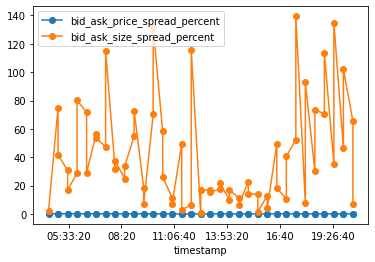

In [324]:
merged_tr_qu.plot(x='timestamp', y=['bid_ask_price_spread_percent','bid_ask_size_spread_percent'], marker='o', kind='line')
